# Text Overlap Detection

To classify whether a creative has image and text overlap or
not. Given an input creative (combination of image and text), it should be able to tell if
the text infringes upon the image and makes a poor creative.

In [1]:
# Installing dependancies
!pip install easyocr --quiet
!pip install ultralytics --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 813.9/813.9 kB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.3/203.3 kB 21.7 MB/s eta 0:00:00


In [ ]:
!git clone https://github.com/Hrushi11/TextOverlapDetection.git

In [69]:
# Importing dependancies
import os
import cv2
import easyocr
import numpy as np
from ultralytics import YOLO

# Definight the Detection class
class ObjectDetection:
  def __init__(self):
      self.reader = easyocr.Reader(['en'])

  # To get the bounding boxes for the text
  def get_text_boxes(self, img_path):
      result = self.reader.readtext(img_path, paragraph=False)
      boxes = []
      for detection in result:
          boxes.append([tuple(point) for point in detection[0]])
      return boxes

  # To get the co-orinates
  def generate_box_coordinates(self, top_left, bottom_right):
      x1, y1 = top_left
      x2, y2 = bottom_right
      top_right = (x2, y1)
      bottom_left = (x1, y2)
      bottom_right = (x2, y2)
      return [top_left, top_right, bottom_left, bottom_right]

  # To get the bounding box the product target to check on
  def get_target_boxes(self, img_path, model):
      results = model.predict(source=img_path, save=True, save_txt=True)
      box = results[0].boxes.data[0]
      p1, p2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
      points = self.generate_box_coordinates(p1, p2)
      return points

  # To check intersection area
  def check_object_intersection(self, box1, box2):
      x1, y1 = box1[0]
      x2, y2 = box1[3]
      x3, y3 = box2[0]
      x4, y4 = box2[3]
      intersection_x1 = max(x1, x3)
      intersection_y1 = max(y1, y3)
      intersection_x2 = min(x2, x4)
      intersection_y2 = min(y2, y4)
      intersection_area = max(0, intersection_x2 - intersection_x1 + 1) * max(0, intersection_y2 - intersection_y1 + 1)
      box1_area = (x2 - x1 + 1) * (y2 - y1 + 1)
      box2_area = (x4 - x3 + 1) * (y4 - y3 + 1)
      overlap_ratio = intersection_area / min(box1_area, box2_area)
      if overlap_ratio >= 0.1:
          return True
      else:
          return False

  # Plotting the overlapping boxes
  def plot_boxes_on_image(self, image, boxes):
      for box in boxes:
          top_left = box[0]
          bottom_right = box[2]
          color = (0, 255, 0)  # Green color for the rectangle
          thickness = 2  # Thickness of the rectangle border
          cv2.rectangle(image, top_left, bottom_right, color, thickness)

      return image
  
  # Final run function to call all the functions
  def run(self, img_path, model):
    text_boxes = self.get_text_boxes(img_path)
    target_boxes = self.get_target_boxes(img_path, model)

    show = []
    for box in text_boxes:
      if self.check_object_intersection(target_boxes, box):
        show.append(box)
    
    # print(show, img_path)
    img = cv2.imread(img_path)
    if len(show): stmnt = 'Overlapping'
    else: stmnt = 'NotOverlapping'

    cv2.putText(img, stmnt, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    self.plot_boxes_on_image(img, show)
    img = cv2.resize(img, (640, 640))

    return stmnt, img

In [70]:
obj_detection = ObjectDetection()
model_detect = YOLO("/content/TextOverlapDetection/TargetDetector.pt")
# dir_path = '/content/TextOverlapDetection/Images'
# filepathsList = os.listdir(dir_path)
# res = []
# for filepath in filepathsList:
#   img_path = dir_path + filepath
#   stmnt, img = obj_detection.run(img_path, model_detect)
#   res.append(stmnt)

In [71]:
# res

## Custom Images


image 1/1 /content/TextOverlapDetection/Images/7_Overlap.png: 640x640 1 Target, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict13
1 label saved to runs/detect/predict13/labels


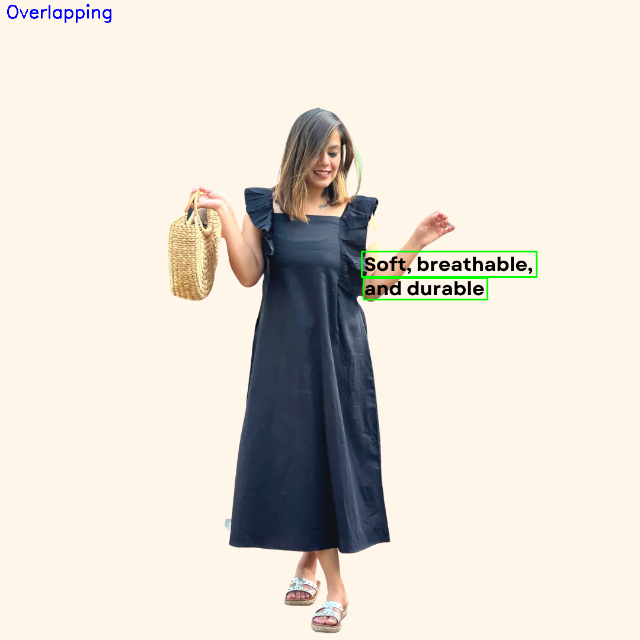

In [72]:
from google.colab.patches import cv2_imshow

img_path = "/content/TextOverlapDetection/Images/7_Overlap.png"
stmnt, img = obj_detection.run(img_path, model_detect)
img = cv2.resize(img, (640, 640))
cv2_imshow(img)